In [1]:
import QuantLib as ql
import matplotlib.pyplot as plt
import numpy as np
from math import log, sqrt, pi, exp
from scipy.stats import norm

Hull-White short rate model 假設如下:  
drt =(θ(t) − art) dt + σ dWt  

In [2]:
# Ask the user to input the variables
S0 = int(input('Initial price of stock: '))
K = int(input('Exercise price of stock: '))
T = int(input('Years to Maturity: '))

# Some given variables
a = 0.4
sigma = 0.1
forward_rate = 0.02
timestep = T * 12
dt = 1/12
num_paths = 3000   # simulation times

Initial price of stock: 100
Exercise price of stock: 150
Years to Maturity: 10


利用quantlib套件，做出 short rate term structure  
以下先定義隨機序列的生成  

In [3]:
day_count = ql.Thirty360()
todays_date = ql.Date(15, 1, 2019)
ql.Settings.instance().evaluationDate = todays_date
spot_curve = ql.FlatForward(todays_date, ql.QuoteHandle(ql.SimpleQuote(forward_rate)), day_count)
spot_curve_handle = ql.YieldTermStructureHandle(spot_curve)

hw_process = ql.HullWhiteProcess(spot_curve_handle, a, sigma)
rng = ql.GaussianRandomSequenceGenerator(ql.UniformRandomSequenceGenerator(timestep, ql.UniformRandomGenerator()))
seq = ql.GaussianPathGenerator(hw_process, T, timestep, rng, False)

建出rate path

In [4]:
def generate_paths(num_paths, timestep):    # num_paths X timestep 的矩陣
    arr = np.zeros((num_paths, timestep+1))
    for i in range(num_paths):
        sample_path = seq.next()
        path = sample_path.value()
        time = [path.time(j) for j in range(len(path))]
        value = [path[j] for j in range(len(path))]
        arr[i, :] = np.array(value)
    return np.array(time), arr

刻劃short rate 路徑

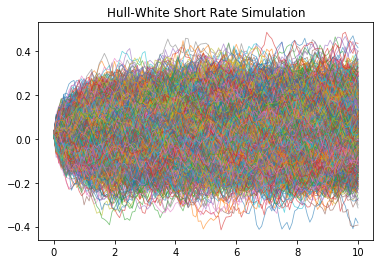

In [5]:
# num_paths
time, mu_paths = generate_paths(num_paths, timestep)
for i in range(num_paths):
    plt.plot(time, mu_paths[i, :], lw=0.8, alpha=0.6)
plt.title("Hull-White Short Rate Simulation")
plt.show()

定義GBM模型  
dX = mu dt + sigma dWt  
其中dWt~N(0,dt)  

In [6]:
def genBrownMotion (T, mu, sigma, S0, dt):
    n = round(T/dt)
    t = np.linspace(0, T, n+1)
    W = [0] + np.random.standard_normal(size = n+1) 
    W = np.cumsum(W)*np.sqrt(dt) # == standard brownian motion
    X = (mu-0.5*sigma**2)*t + sigma*W 
    S = S0*np.exp(X) # == geometric brownian motion
    plt.plot(t, S)
    return S

將每條rate path代入GBM模型，算出股價S  

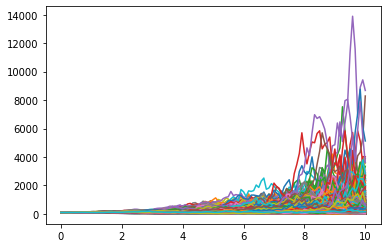

In [7]:
paths = []
for i in range(0, num_paths):
    paths.append(genBrownMotion(T, mu_paths[i], sigma, S0, dt))
plt.show()

各別算出 call、put payoff，取期望值後折現

In [8]:
# call and put payoff
call_num = 0
put_num = 0
for i in range(len(paths)):
    call_num += (1/num_paths) * max (0, paths[i][-1] - K)
    put_num += (1/num_paths) * max(0, K - paths[i][-1])

# discount
call_price = call_num/(1 + 0.02/12)**(timestep)
put_price = put_num/(1 + 0.02/12)**(timestep)

print('Call price = %.4f' % call_price)
print('Put price = %.4f' % put_price)


Call price = 148.9596
Put price = 30.5427
